# K Means From Scratch

## The Basic Idea

Given a dataset where each observed example has a set of features, but has
**no** labels. What can we do? One task we can perform on a data set with no labels is to find groups of data in our dataset
which are similar to one another -- called clusters.

K Means is a clustering algorithm. It stores k centroids that it uses to define clusters. A point
is considered to be in a particular cluster if it is closer to that cluster's centroid that any other
centroid.

## The Algorithm

We are given a training set $\{ x^1, x^2,..., x^m \}$, and want to group the data into a few
cohesive "clusters". Here, we are given feature vectors for each data point $x^i \in\mathbb{R}^n$
as usual. Our goal is to predict k centroids **and** a label $c^i$ for each datapoint.

1. Initialize **cluster centroids** $\mu_1, \mu_2,...,\mu_k\in\mathbb{R}^n$ randomly.
2. Repeat until convergence:

$$
\text{Set } c^i := arg \min_{j} \Vert x^i - \mu_j\Vert ^2 \text{ }\text{  for every i}
$$

$$
\text{Set } \mu_j := \frac{\sum_{i=1}^m \chi_{\{c^i = j\}}x^i}{\sum_{i=1}^m \chi_{\{c^i = j\}}} \text{ }\text{  for every j}
$$


We can write the algorithm using 5 key steps:
1. randomly select centroids.
2. calculate distance at each point and assign each point to cluster.
3. calculate average of the assigned point.
4. move centroid to the new position.
5. repeat steps 2-4 until cluster assignment is not changed.

## Implementation of steps from 1 to 5

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

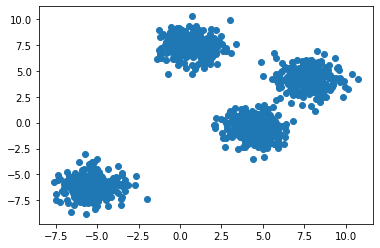

In [2]:
X,y = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=95)
plt.scatter(X[:,0], X[:,1])

## Step 1 randomly select centroids.

In [3]:
# step 1
def get_first_centroid(data, k):
    n = data.shape[1]
    centroids = [0]*k
    for j in range(k):
        temp = [0]*n
        for i in range(n):
            ith = data[:,i]
            temp[i] = np.random.randint(.8*ith.min(), .8*ith.max())
        centroids[j] = temp
    return np.array(centroids)

first_centroid = get_first_centroid(X,4)
print(first_centroid)

[[ 7  6]
 [ 5 -5]
 [ 5  1]
 [ 0  0]]


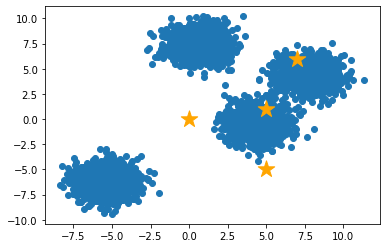

In [4]:
X,y = make_blobs(n_samples=5000, centers=4, n_features=2, random_state=95)
plt.scatter(X[:,0], X[:,1])
plt.scatter(first_centroid[:,0], first_centroid[:,1],marker='*', s=300, c='orange')

## Step 2 calculate distance at each point and assign each point to cluster

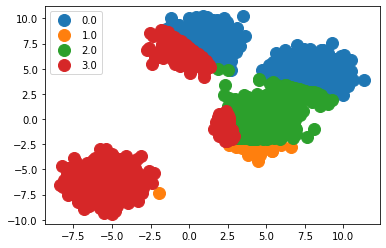

In [5]:
import pandas as pd

def cal_assignments(data, centroids):
    m = data.shape[0]
    args = [0]*m
    for i in range(m):
        distances = [np.linalg.norm(centroid-data[i]) for centroid in centroids]
        argument = np.argmin(distances)
        args[i] = argument

    return np.c_[data, args]

assignments = cal_assignments(X, first_centroid)

# Generate Data
df = pd.DataFrame(assignments)
groups = df.groupby(2)

# Plot
fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    ax.plot(group[0], group[1], marker='o', linestyle='', ms=12, label=name)
ax.legend(numpoints=1, loc='upper left')


## Step 3-4 calculate average of the assigned point then 4 move centroid to the new position.

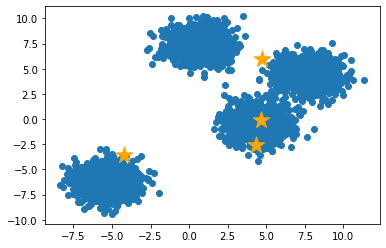

In [6]:
def cal_averages(data):
    assigns = list(set(data[:,-1]))
    new_centroids = []
    for assign in assigns:
        temp = data[data[:,-1] == assign, :-1]
        new_centroids.append(np.mean(temp, axis=0))
    
    return np.array(new_centroids)

new_centroids = cal_averages(assignments)
plt.scatter(X[:,0], X[:,1])
plt.scatter(new_centroids[:,0], new_centroids[:,1],marker='*', s=300, c='orange')

## Step 5 repeat steps 2-4 until cluster assignment is not changed.

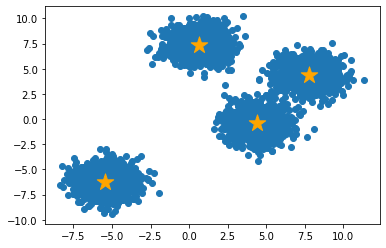

In [7]:
MAXITERATION = 500
count = 1
while (not np.array_equal(first_centroid, new_centroids, equal_nan=True)) and (count < MAXITERATION):
    first_centroid = new_centroids[:]
    assignments = cal_assignments(X, first_centroid)
    new_centroids = cal_averages(assignments)

    count += 1
    

plt.scatter(X[:,0], X[:,1])
plt.scatter(new_centroids[:,0], new_centroids[:,1],marker='*', s=300, c='orange')

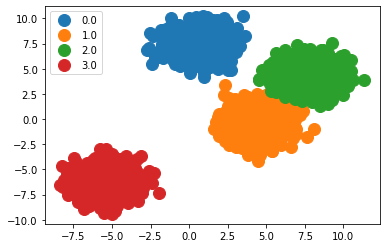

In [8]:
# Generate Data
df = pd.DataFrame(assignments)
groups = df.groupby(2)

# Plot
fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    ax.plot(group[0], group[1], marker='o', linestyle='', ms=12, label=name)
ax.legend(numpoints=1, loc='upper left')

## Expectation Maximization

Note that K-Means is really just the Expectation Maximization algorithm applied to a particular
naive bayes model.

In the classic naive bayes model with a class variable which can take on discrete values
(with domain size k) and a set of feature variables, each of which can take on a continuous value. 
The conditional probability distribution $P(f_i=x | C = c)$ is going to be slightly different than
usual. Instead of storing this conditional probability as a table, we are going to store it a single
normal gaussian distribution, with its own mean and a standard deviation of 1. Specifically, this means
that: $P(f_i=x| C=c)\sim\mathcal{N}({\mu_{c,i},1)}$.

The whole goal of Naive Bayes to to find $P(y|x)$. $P(C=c|f_i=x)$ is proportional to
 $P(f_i=x|C=c)*P(C=c)$, so we need to figure out $P(f_i=x| C=c)$.

Since we don't have the given "correct" classes for each observation, let's apply an EM algorithm approach 
to finding this $\mu_{c,i}$. Remember, EM starts with randomly initializing model parameters, 
and then repeats a two-step process of (E) assigning values to the unknown variables based of the parameters, 
and (M) calculating the parameters based off the data.


1. Come up with our unknown value (in this case the outcome it corresponds to), given the data. It turns out the best estimate for finding our unknown means is to use Euclidean distance, or just taking the mean. In other words, this is to say "for each point, find the mean that it's closer to."
2. Come up with the best parameter estimates based off the fact that you now have the data and the "guessed" outcomes from step 1. Turns out, the best estimate you can have for these parameters (MLE) is just the mean.
3. Repeat 1 and 2 until convergence.